In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Simulação exemplo 1: sem grafos

In [164]:
O = [0,1] # lista de opinioes
N = 100 # numero de atores da rede
T = 100000 # numero de periodos

In [29]:
def get_influencers(position,N):
    
    if position == 1:
        inf = [N,2]
    elif position == N:
        inf = [N-1,1]
    else:
        inf = [position-1,position+1]
    
    return(inf)

In [228]:
O = [0,1] # lista de opinioes
N = 100 # numero de atores da rede
T = 500000 # numero de periodos

In [230]:
X = random.choices(O,k=N)
print(np.mean(X))

for i in range(T):
    
    # escolher o ator em {1,...,N}
    An = random.randint(1,N)
    
    # calcular os 2 influenciadores de An
    inf1,inf2 = get_influencers(An,N)
    
    # coletar a opiniao dos influenciadores
    op1,op2 = X[inf1-1],X[inf2-1]
    
    # calcular a quantidade de opinioes +1 dos influenciadores = Un+
    positive_ops = op1+op2
    
    # calcular a probabilidade de opiniao +1 := p+
    # obs: probabilidade de opiniao -1 = 1-p+
    prob_positive = positive_ops/2
    
    # escolher a nova opiniao de An -> +1 com prob p+ e -1 com prob 1-p+
    new_op = np.random.choice(2, 1, p=[1-prob_positive,prob_positive])[0]
    
    # alterar o vetor de opinioes
    X[An-1] = new_op
    
print(np.mean(X))

0.59
0.0


## Simulacao exemplo 1: com grafos

In [140]:
def get_influencers(position,N):
    
    if position == 1:
        inf = [N,2]
    elif position == N:
        inf = [N-1,1]
    else:
        inf = [position-1,position+1]
    
    return(inf)

In [150]:
def initialize_network(N,O):
    
    X = random.choices(O,k=N)
    
    G = nx.DiGraph()
    G.add_nodes_from(range(1,N))
    
    for i in range(1,N+1):
        inf1,inf2 = get_influencers(i,N)
        G.add_edges_from(([inf1,i],[inf2,i]))
    
    df = pd.DataFrame()
    df['node'] = range(1,N+1)
    df['opinion']=X
    
    node_attr = df.set_index('node').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    
    return(G)

In [151]:
def color(a):
    if a == 1:
        return('yellow')
    else:
        return('orange')

In [349]:
def show_network(G):
    
    opinions = nx.get_node_attributes(G,'opinion').values()
    pos = nx.circular_layout(G)

    nx.draw(G, with_labels=True, node_size=500, pos=pos, node_color=list(map(color,opinions)))
    plt.show()

In [362]:
def update_graph(G):
    
    N = len(G.nodes)
    
    An = random.randint(1,N)
    influencers = list(G.neighbors(An))
    opinions = nx.get_node_attributes(G,'opinion')
    influencers_opinions = [opinions[x] for x in influencers]
    
    prob_positive = sum(influencers_opinions)/len(influencers)
    new_op = np.random.choice(2, 1, p=[1-prob_positive,prob_positive])[0]
    G.nodes[An]['opinion'] = new_op
    
    return(G)

In [369]:
def update_graph_T_times(G,T,show=False):
    
    for i in range(T):
        G = update_graph(G)
     
    if show==True:
            show_network(G)
            
    return(G)

In [621]:
def update_graph_until_consensus(G):
    
    k=0
    N = len(G.nodes)
    evolution = []
    sum_of_opinions = sum(nx.get_node_attributes(G,'opinion').values())
     
    while sum_of_opinions!=0 and sum_of_opinions!=N:
        G=update_graph(G)
        sum_of_opinions = sum(nx.get_node_attributes(G,'opinion').values())
        evolution.append(sum_of_opinions)
        k+=1
            
    return(k,evolution)

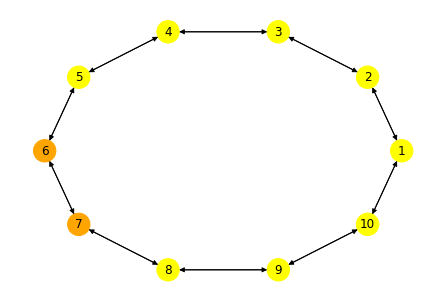

The initial number of actors with opinion +1 is 8.
This network has taken 154 rounds to reach consensus.


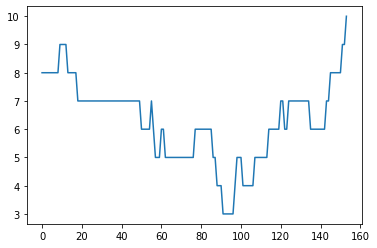

In [438]:
O = [0,1] # lista de opinioes
G=initialize_network(10,O)
show_network(G)

opinion_positive = sum(nx.get_node_attributes(G,'opinion').values())
T,opinion_evolution = update_graph_until_consensus(G)
print('The initial share of actors with opinion +1 is {}%.'.format(100*opinion_positive/len(G.nodes)))
print('This network has taken {} rounds to reach consensus.'.format(T))
plt.plot(opinion_evolution);

## Simulacao exemplo 2

In [571]:
def get_influencers(position,N):
     
    x=position[0]
    y=position[1]
    
    if x > 1 and x < N and y > 1 and y < N:
        inf = [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]
    elif ((x>1 and x<N) and (y==1 or y==N)):
        if y==1:
            inf = [(x-1,y),(x+1,y),(x,y+1),(x,N)]
        else:
            inf = [(x-1,y),(x+1,y),(x,y-1),(x,1)]
    elif ((y>1 and y<N) and (x==1 or x==N)):
        if x==1:
            inf = [(x,y-1),(x,y+1),(x+1,y),(N,y)]
        else:
            inf = [(x,y-1),(x,y+1),(x-1,y),(1,y)] 
    else:
        if x==1 and y==1:
            inf = [(1,2),(2,1),(N,1),(1,N)]
        elif x==N and y==N:
            inf = [(N-1,N),(N,N-1),(1,N),(N,1)]
        elif x==1 and y==N:
            inf = [(1,N-1),(2,N),(N,N),(1,1)]
        else:
            inf = [(N-1,1),(N,2),(N,N),(1,1)]
    
    return(inf)

In [572]:
def product(*args):
    if not args:
        return iter(((),)) # yield tuple()
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

In [573]:
def initialize_network(N,O):
    
    N2 = N**2
    X = random.choices(O,k=N2)
    actors = list(product(range(1,N+1),range(1,N+1)))
    
    G = nx.DiGraph()
    G.add_nodes_from(actors)
    
    for i in range(1,N+1):
        for j in range(1,N+1):
            inf1,inf2,inf3,inf4 = get_influencers((i,j),N)
            G.add_edges_from(([inf1,(i,j)],[inf2,(i,j)],[inf3,(i,j)],[inf4,(i,j)]))
    
    df = pd.DataFrame()
    df['node'] = actors
    df['opinion']=X
    
    node_attr = df.set_index('node').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    
    return(G)

In [653]:
G=initialize_network(10,O)

In [585]:
# OPTIONAL WAY WE COULD CREATE THIS GRAPH WITH NETWORK X
#H=nx.grid_2d_graph(10, 10, periodic=True)

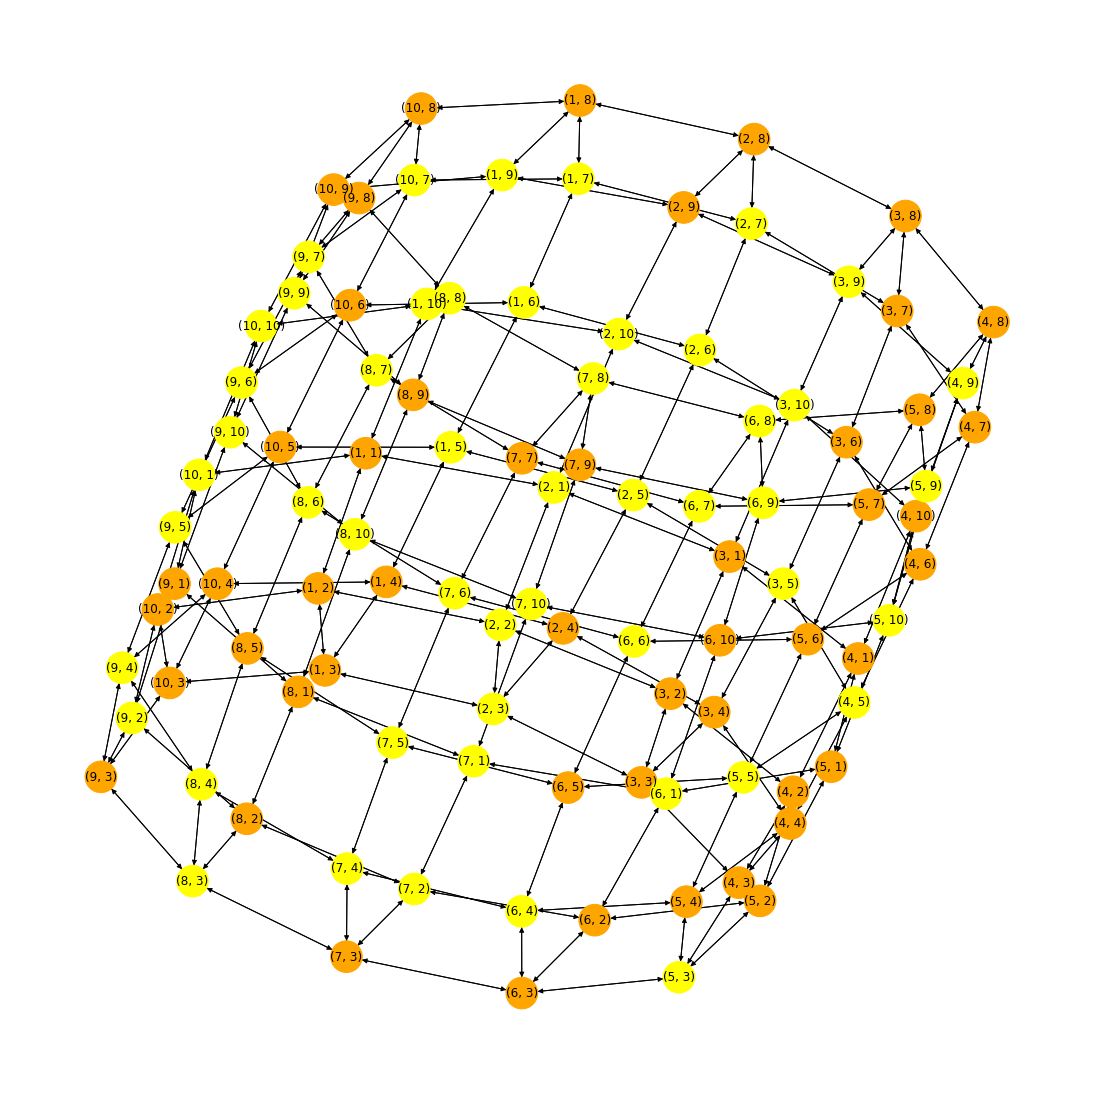

In [597]:
plt.figure(figsize=(15,15)) 
nx.draw(G,with_labels=True,node_size=1000,node_color=list(map(color,opinions)))

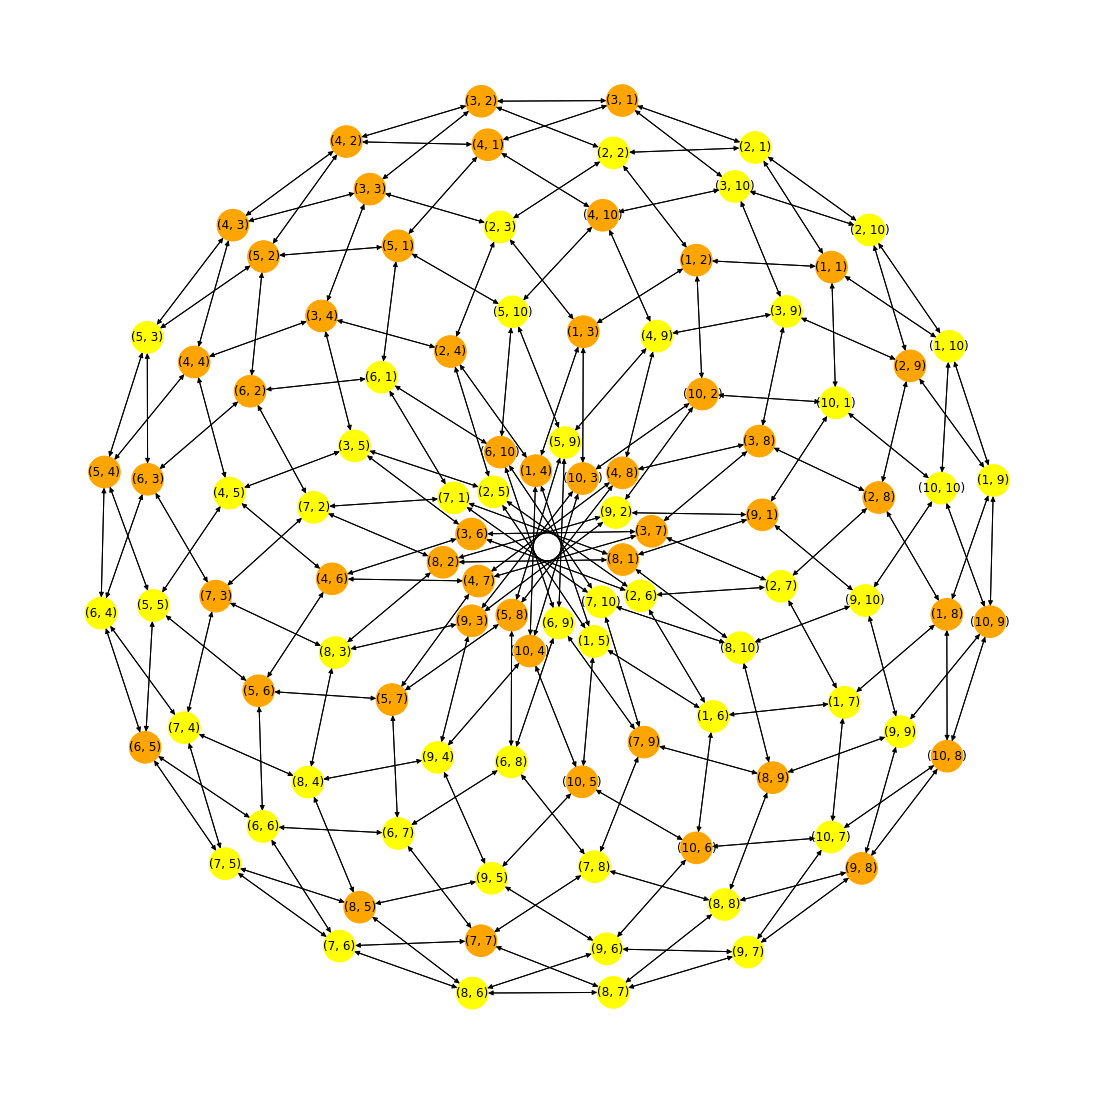

In [615]:
plt.figure(figsize=(15,15)) 
nx.draw(G,with_labels=True,node_size=1000,node_color=list(map(color,opinions)),pos=nx.kamada_kawai_layout(G))

In [600]:
random.randint(1,2)

1

In [697]:
def update_graph(G):
    
    N2 = len(G.nodes)
    N=np.sqrt(N2)
    
    x = random.randint(1,N)
    y = random.randint(1,N)
    An = (x,y)
    influencers = list(G.neighbors(An))
    opinions = nx.get_node_attributes(G,'opinion')
    influencers_opinions = [opinions[x] for x in influencers]
    
    prob_positive = sum(influencers_opinions)/len(influencers)
    new_op = np.random.choice(2, 1, p=[1-prob_positive,prob_positive])[0]
    G.nodes[An]['opinion'] = new_op
    return(G)

In [700]:
def update_graph_until_consensus(G):
    
    k=0
    N = len(G.nodes)
    evolution = []
    sum_of_opinions = sum(nx.get_node_attributes(G,'opinion').values())
     
    while sum_of_opinions!=0 and sum_of_opinions!=N:
        G=update_graph(G)
        sum_of_opinions = sum(nx.get_node_attributes(G,'opinion').values())
        evolution.append(sum_of_opinions)
        k+=1
            
    return(k,evolution)

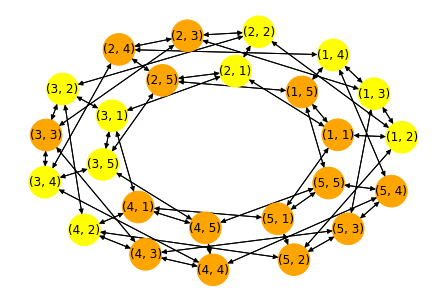

The number of actors in this network is 25.
The initial share of actors with opinion +1 is 40.0%.
This network has taken 107 rounds to reach consensus.


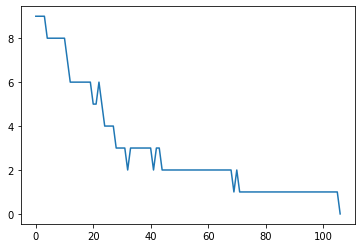

In [721]:
O = [0,1] # lista de opinioes
G=initialize_network(5,O)
opinions=nx.get_node_attributes(G,'opinion').values()
nx.draw(G,with_labels=True,node_size=1000,node_color=list(map(color,opinions)),pos=nx.kamada_kawai_layout(G))
plt.show()

opinion_positive = sum(nx.get_node_attributes(G,'opinion').values())
T,opinion_evolution = update_graph_until_consensus(G)
print('The number of actors in this network is {}.'.format(len(G.nodes)))
print('The initial share of actors with opinion +1 is {}%.'.format(100*opinion_positive/len(G.nodes)))
print('This network has taken {} rounds to reach consensus.'.format(T))
plt.plot(opinion_evolution);

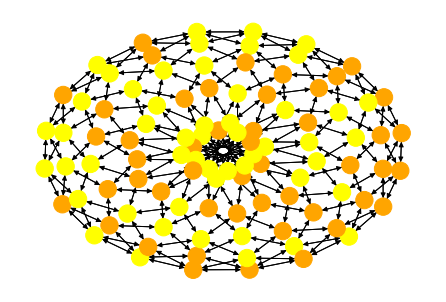

The number of actors in this network is 100.
The initial share of actors with opinion +1 is 52.0%.
This network has taken 5638 rounds to reach consensus.


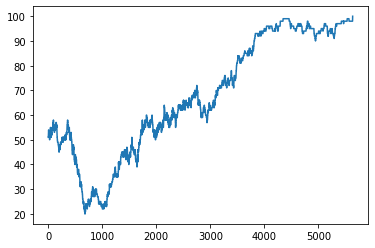

In [724]:
O = [0,1] # lista de opinioes
G=initialize_network(10,O)
opinions=nx.get_node_attributes(G,'opinion').values()
nx.draw(G,with_labels=False,node_size=300,node_color=list(map(color,opinions)),pos=nx.kamada_kawai_layout(G))
plt.show()

opinion_positive = sum(nx.get_node_attributes(G,'opinion').values())
T,opinion_evolution = update_graph_until_consensus(G)
print('The number of actors in this network is {}.'.format(len(G.nodes)))
print('The initial share of actors with opinion +1 is {}%.'.format(100*opinion_positive/len(G.nodes)))
print('This network has taken {} rounds to reach consensus.'.format(T))
plt.plot(opinion_evolution);